# Facies classification using Machine Learning
#### Joshua Poirier, [NEOS](https://www.neosgeo.com)
2016 SEG Machine Learning Competition

This notebook aims to extend Brendon Hall's "Facies classification using Machine Learning" notebook. Here I will be using the R programming language and employing a **custom minimum distance** approach. The data set used is from a class exercise from the University of Kansas on Neural Networks and Fuzzy Systems. It's based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields.  

The dataset I will be using includes log data from nine wells that have been labeled with facies type based on core observation. We will use this data to train our model and predict the facies for two hold-out wells (for which we have access to log data but not facies type).   

To begin, let's print out the version of R I'm running.

In [11]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          2.4                         
year           2016                        
month          03                          
day            10                          
svn rev        70301                       
language       R                           
version.string R version 3.2.4 (2016-03-10)
nickname       Very Secure Dishes          

Now I will start by loading in the training data and doing some preliminary cleaning.

### Getting and cleaning data

In [2]:
options(warn=-1)

suppressMessages(library(dplyr))
source("loadData.R")

# load data
"Raw data:"
raw <- loadData()
format(head(raw,3), digits=3)

# clean data
"Cleaned data:"
clean <- cleanData(raw)
format(head(clean,3), digits=3)

# center and scale select features
"Centered and scaled data:"
wells <- unique(clean$Well.Name)
cs <- mutate(group_by(clean, Well.Name), 
             GR=scale(GR), 
             ILD_log10=scale(ILD_log10), 
             DeltaPHI=scale(DeltaPHI), 
             PHIND=scale(PHIND), 
             PE=scale(PE))
df <- cs
format(head(df,3), digits=3)

[1] "Raw data:"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3,A1 SH,SHRIMPLIN,2793,77.5,0.664,9.9,11.9,4.6,1,1.000
3,A1 SH,SHRIMPLIN,2794,78.3,0.661,14.2,12.6,4.1,1,0.979
3,A1 SH,SHRIMPLIN,2794,79.0,0.658,14.8,13.1,3.6,1,0.957


[1] "Cleaned data:"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793,77.5,0.664,9.9,11.9,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2794,78.3,0.661,14.2,12.6,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794,79.0,0.658,14.8,13.1,3.6,FALSE,0.957


[1] "Centered and scaled data:"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793,0.216,0.01855,0.512,-0.0487,0.421,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2794,0.237,0.00567,1.517,0.0736,-0.133,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794,0.258,-0.00721,1.657,0.1648,-0.687,FALSE,0.957


Three data frames are shown above. The first shows the raw data (as it exists in the \*.csv) file. The *cleaned* data converts the Facies feature from integer indicators to something more descriptive (FSiS more clearly indicates fine siltstone than the number 3 does!) - this will be useful when looking at the data moving forward. The *cleaned* data also converts the two-level **NM_M** feature into boolean **isMarine** - again this shouldn't impact our models but is more intuitive.  

Finally, the *centered and scaled* data centers and scales the log data on a well-by-well basis.

### Feature engineering  

I'll now add a couple of features which will be used during **facies sequencing** (more on this later). First, *FmThickness* is the formation thickness within that particular well.  Second, *FmRelDepth* is the relative formation depth.

In [3]:
library(dplyr)

wells <- unique(df$Well.Name)

# calculate formation thickness on a well-by-well basis
df <- mutate(group_by(df, Formation, Well.Name), FmThickness=max(Depth)-min(Depth)+.5)

# calculate relative formation depth
df$FmRelDepth <- 1 - df$RELPOS

format(head(df), digits=3)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS,FmThickness,FmRelDepth
FSiS,A1 SH,SHRIMPLIN,2793,0.216,0.01855,0.512,-0.0487,0.421,FALSE,1.000,21.5,0.000
FSiS,A1 SH,SHRIMPLIN,2794,0.237,0.00567,1.517,0.0736,-0.133,FALSE,0.979,21.5,0.021
FSiS,A1 SH,SHRIMPLIN,2794,0.258,-0.00721,1.657,0.1648,-0.687,FALSE,0.957,21.5,0.043
FSiS,A1 SH,SHRIMPLIN,2794,0.447,-0.02009,1.447,0.1770,-0.797,FALSE,0.936,21.5,0.064
FSiS,A1 SH,SHRIMPLIN,2795,0.139,-0.05444,1.353,0.2118,-0.908,FALSE,0.915,21.5,0.085
FSiS,A1 SH,SHRIMPLIN,2796,0.122,-0.10167,1.470,0.2278,-0.687,FALSE,0.894,21.5,0.106


### Facies sequencing functions  

I'm going to build a data frame containing information on all the facies sequences observed in all the wells. Here I define a facies sequence as a contiguous set of the same facies. For example, SS - SS - SS - SS - MS - MS - D - D - D would represent three facies sequences (one for the 4 SS's, one for 2 MS's, and one for the 3 D's).

To do this I'll need some functions (additional functions are kept in this directory's *sequencing.R* file - kept there for brevity). This first function we show here builds a single-rowed data frame containing information on a single data frame:

* Formation - formation this facies sequence belongs to (i.e. **A1 SH**)  
* Well.Name - well this facies sequence was observed (i.e. **SHRIMPLIN**)  
* Top - depth representing the top of the facies sequence  
* Base - depth representing the bottom of the facies sequence  
* FmThickness - thickness of entire formation (not thickness of facies sequence)  
* Facies - facies type of the sequence  
* FmRelThickness - thickness of the facies sequence relative to the entire formation  
* GR_mean - average gamma-ray observed over the facies sequence  
* ILD_log10_mean - average deep resistivity observed over the facies sequence  
* dPhi_mean - average difference between neutron and density porosities observed over the facies sequence  
* PHI_mean - average porosity observed over the facies sequence  
* PE_mean - average photoelectric effect observed over the facies sequence  

In [8]:
# function to build a single-rowed data frame with information regarding a contiguous facies sequence
# ---------------------------------------------------------------------------------------------------
# SUMMARY OF ARGUMENTS
# formation = formation this facies sequence belongs to
# well = well data this facies sequence belongs to
# fmThickness = thickness of the formation (not the facies sequence)
# facies = facies type in question (SS, FSiS, etc.)
# top = shallowest depth of this facies sequence
# base = deepest depth of this facies sequence
# df = data frame containing all observations of this facies sequence (from the loaded data)

# SUMMARY OF RETURN
# seq_df = single-rowed data frame containing information on a contiguous facies sequence
# ---------------------------------------------------------------------------------------------------
buildSeqRow <- function(formation, well, fmThickness, facies, top, base, df) {
    
    seq_df <- data.frame(Formation = formation,
                         Well.Name = well,
                         Top = top,
                         Base = base,
                         FmThickness = fmThickness,
                         Facies = facies,
                         FmRelThickness = (base-top)/fmThickness,
                         GR_mean=mean(df$GR), 
                         ILD_log10_mean=mean(df$ILD_log10), 
                         dPhi_mean=mean(df$DeltaPHI), 
                         PHI_mean=mean(df$PHIND), 
                         PE_mean=mean(df$PE, na.rm=T)
                        )
    seq_df
}

Next I build the function to loop over all formations in the data set (and in subsequent functions, tucked in *sequencing.R*, the wells and observations). It will ultimately build and return a data frame containing information on each contiguous facies sequence in a given data frame.

In [9]:
source("sequencing.R")

# function to build a data frame of each contiguous facies sequence
# ---------------------------------------------------------------------------------------------------
# SUMMARY OF ARGUMENTS
# df = data frame containing all log observations (eg. the loaded data)
#
# SUMMARY OF RETURN
# seq_df = data frame containing data on each contiguous facies sequence
# ---------------------------------------------------------------------------------------------------
faciesSequencing <- function(df) {
    seq_df <- data.frame()
    formations <- unique(df$Formation)

    for (f in formations) {
        df_f <- df[df$Formation == f,]
        seq_df <- rbind(seq_df, formationSequencing(df_f, f))
    } 
    
    seq_df
}

### Trial training  

Since this is a somewhat novel approach, let's try it out by isolating two arbitrary wells as a cross-validation set. Here I will ignore data with the well label **RECRUIT F9** because the approach tries to leverage spatial location - for which the recruited data is not as robust (no consistent sampling).  

For this run I will use the **SHRIMPLIN** and **CHURCHMAN BIBLE** wells as an arbitrarily chosen cross-validation/test set. I choose two wells to emulate the contest conditions by which we are predicting facies for two hold-out wells.  

The **getOutAndVote** function performs facies sequencing on the training data and projects the facies of each well onto the test data (based on the relative formation depths). Also projected for each training well is the data-space distance between the test well's data observation and the average for the relevant facies sequence. Each training well gets to *vote* for their facies weighted using inverse distance weighting (data distance as described). The training well with the most weighted votes (**minimum distance**) is elected as the predicted facies for that test observation.  

Once the predictions are in place I evaluate my predictions using micro-averaged F1-score. The functions for this are tucked away in *accuracyMetrics.R*, and are essentially the work of [sunliangms](https://github.com/Azure/Azure-MachineLearning-DataScience/blob/master/Utilities/R/MultiClassEvaluation/multi_class_measure.R).  

Finally, note that I am recording the time at the beginning and end of the code block. I will post the computation time (real-time) at the end to get a loose sense of computational complexity.

In [10]:
library(dplyr)
source("voting.R")
source("accuracyMetrics.R")
source("sequencing.R")

t0 <- Sys.time()

wells <- unique(df$Well.Name)
wells <- wells[!wells %in% c("Recruit F9")]

# use SHRIMPLIN & CHURCHMAN BIBLE as test wells
train <- df[df$Well.Name != "SHRIMPLIN" & df$Well.Name != "CHURCHMAN BIBLE" & df$Well.Name != "Recruit F9",]
test <- df[df$Well.Name == "SHRIMPLIN" | df$Well.Name == "CHURCHMAN BIBLE",]

testPrime <- getOutAndVote(train, test)
testPrime <- electClass(testPrime,
                        tallyVotes(testPrime, unique(train$Well.Name), p=1.75))
testFinal <- subset(testPrime, select=c(Formation, Well.Name, Depth,
                                       GR, ILD_log10, DeltaPHI, PHIND, PE, isMarine, RELPOS,
                                       Facies, Predicted))

format(head(testFinal,3), digits=3)
"F1-score:"
myF1Metric(testFinal$Predicted, testFinal$Facies)

tn <- Sys.time()
"Time elapsed:"
print(tn-t0)

Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS,Facies,Predicted
A1 SH,SHRIMPLIN,2793,0.216,0.01855,0.512,-0.0487,0.421,FALSE,1.000,FSiS,FSiS
A1 SH,SHRIMPLIN,2794,0.237,0.00567,1.517,0.0736,-0.133,FALSE,0.979,FSiS,FSiS
A1 SH,SHRIMPLIN,2794,0.258,-0.00721,1.657,0.1648,-0.687,FALSE,0.957,FSiS,FSiS


[1] "F1-score:"

[1] 0.5325714

[1] "Time elapsed:"

Time difference of 23.50804 secs


Here I achieved an F1-score of **0.53** - not bad but not winning the contest as of this writing. Nevertheless, I feel this novel approach is worth pursuing through the end. It also took just over 23 seconds to run - pretty quick by machine learning standards.

### Cross-validation by number of training wells  

It is intuitive to expect any machine learning algorithm for this contest to perform better with more data (from more wells). To simulate contest conditions it is reasonable to use each combination of wells in the training data as a cross-validation/test set to evaluate our algorithms performance.  

Similarly, for each cross-validation well pair, I will use every possible combination of the remaining wells in the training set (each well alone, each possible well pair, each possible well ternary, etc). This will allow me to see how the number of training wells impacts predictive performance. I will store these results in a data frame and we can run some statistics on it later.

In [114]:
source("voting.R")
source("accuracyMetrics.R")

t0 <- Sys.time()

f1 <- data.frame()

for (wi in 1:(length(wells)-1)) {
    for (wj in (wi+1):length(wells)) {
        test <- df[df$Well.Name == wells[wi] | df$Well.Name == wells[wj],]
        trainWells <- wells[!wells %in% c(as.character(wells[wi]), as.character(wells[wj]))]
        
        for (i in 1:length(trainWells)) {
            trainWellCombos <- combn(trainWells, i, simplify=F)
            for (combo in trainWellCombos) {
                train <- df[df$Well.Name %in% as.vector(combo),]
                
                # ensure training set observes all formations in the test set
                if (sum(unique(test$Formation) %in% unique(train$Formation)) == length(unique(test$Formation))) {
                    testPrime <- getOutAndVote(train, test)
                    votes <- tallyVotes(testPrime, unique(train$Well.Name), p=1.75)
                    testPrime <- electClass(testPrime, votes)
                    testFinal <- subset(testPrime, select=c(Formation, Well.Name, Depth,
                                                            GR, ILD_log10, DeltaPHI, PHIND, PE, isMarine, RELPOS,
                                                            Facies, Predicted))
                    
                    f1_i <- myF1Metric(testFinal$Predicted, testFinal$Facies)
                    f1 <- rbind(f1, data.frame(testwell1=wells[wi], testwell2=wells[wj], nTrain=i, f1=f1_i))
                }
            }
        }
    }
}

format(head(f1), digits=3)

tn <- Sys.time()
print(tn-t0)

testwell1,testwell2,nTrain,f1
SHRIMPLIN,ALEXANDER D,1,0.482
SHRIMPLIN,ALEXANDER D,1,0.458
SHRIMPLIN,ALEXANDER D,1,0.531
SHRIMPLIN,ALEXANDER D,1,0.423
SHRIMPLIN,ALEXANDER D,2,0.539
SHRIMPLIN,ALEXANDER D,2,0.501


Time difference of 15.91658 hours


Notice that the above computation took nearly **16 hours**! This is because it ran many many of those ~ 23 second models - one for each combination of training wells for each combination of cross-validation/test wells.

Now we have calculated models for all possible combinations of 2 test well pairs using all possible combinations of training wells (any number of training wells). Let's calculate the 95% confidence intervals for the f1-scores across the number of training wells. I expect the f1-scores to increase with additional training wells; and also have the interval ranges decrease. 

We can then forecast the expected (mean) f1-score and 95% confidence intervals when using the full training set. This would is the conditions when predicting the STUART and CRAWFORD wells using this method.

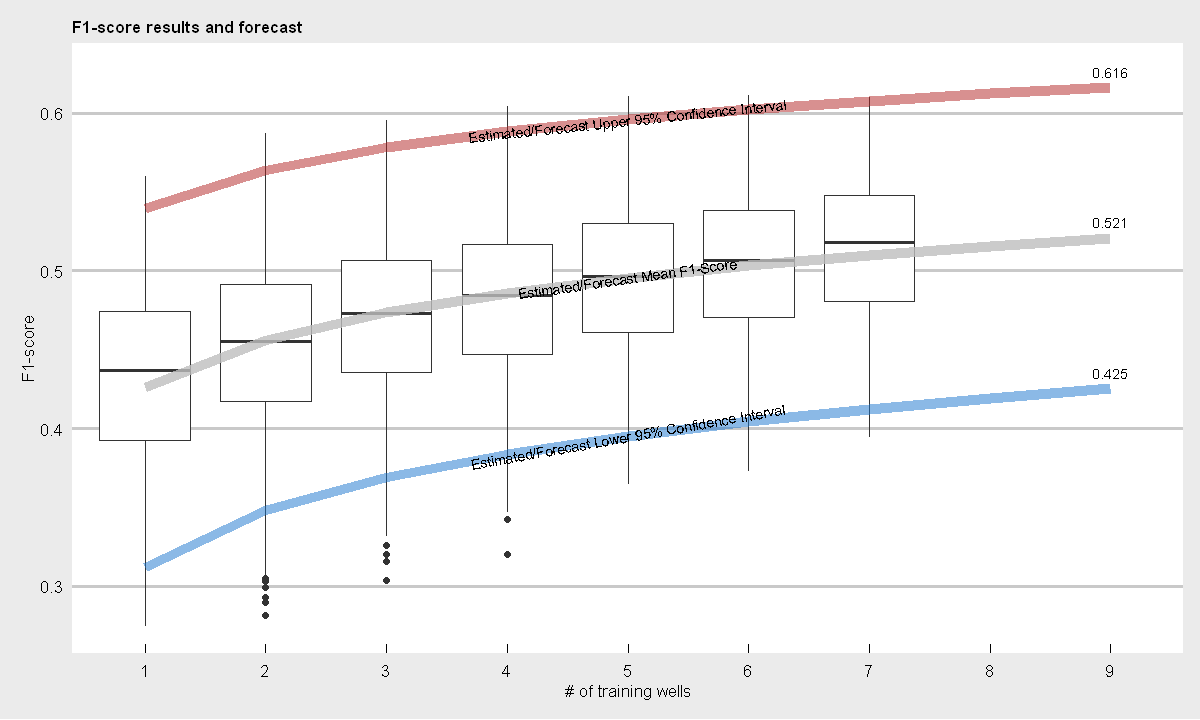

In [182]:
options(repr.plot.width=10, repr.plot.height=6)

library(ggplot2)
library(ggthemes)

# calculate mean, standard deviation, and 95% confidence intervals for models by the number of training wells
means <- tapply(f1$f1, f1$nTrain, mean)
sds <- tapply(f1$f1, f1$nTrain, sd)
lower95 <- means - 2 * sds
upper95 <- means + 2 * sds
f1_summary <- data.frame(nTrain=1:length(lower95), lower95=lower95, mean=means, upper95=upper95)

# model the mean and 95% confidence interval using a linear model (with natural log applied to # training wells)
fit_lower95 <- lm(lower95 ~ log(nTrain), data=f1_summary)
fit_mean <- lm(mean ~ log(nTrain), data=f1_summary)
fit_upper95 <- lm(upper95 ~ log(nTrain), data=f1_summary)

# estimate/forecast f1-score (mean) and it's 95% confidence interval for up to 9 wells (entire training set)
predict <- data.frame(nTrain=1:9, lower95=rep(NA,9), mean=rep(NA,9), upper95=rep(NA,9))
predict$lower95 <- predict(fit_lower95, predict)
predict$mean <- predict(fit_mean, predict)
predict$upper95 <- predict(fit_upper95, predict)

# plot boxplot of f1-scores and lines showing how expected f1-score and 95% confidence interval change
# with # of training wells included in model
p <- ggplot(f1, aes(factor(nTrain), f1)) + geom_boxplot() + theme_economist_white() +
    labs(x="# of training wells", y="F1-score", title="F1-score results and forecast") +
    geom_line(data=predict, aes(group=1, y=lower95), col="dodgerblue3", size=3, alpha=.5) +
    geom_line(data=predict, aes(group=1, y=mean), col="gray", size=3, alpha=.8) +
    geom_line(data=predict, aes(group=1, y=upper95), col="firebrick", size=3, alpha=.5) +
    geom_text(aes(x=9, y=predict$lower95[9]+.01, label=round(predict$lower95[9], 3)), size=3) +
    geom_text(aes(x=9, y=predict$mean[9]+.01, label=round(predict$mean[9], 3)), size=3) +
    geom_text(aes(x=9, y=predict$upper95[9]+.01, label=round(predict$upper95[9], 3)), size=3) +
    geom_text(aes(x=5, y=predict$lower95[5], label="Estimated/Forecast Lower 95% Confidence Interval"), size=3, angle=10) +
    geom_text(aes(x=5, y=predict$mean[5], label="Estimated/Forecast Mean F1-Score"), size=3, angle=8) +
    geom_text(aes(x=5, y=predict$upper95[5], label="Estimated/Forecast Upper 95% Confidence Interval"), size=3, angle=6) +
    theme(plot.title=element_text(size=10), axis.title=element_text(size=10), axis.text=element_text(size=10))

p 

After viewing the boxplot alone I decided to approximate/forecast the expected (mean) f1-score and its 95% confidence interval by fitting a linear model (with a natural logarithm applied to independent data (# of training wells).

So with the entire training set (all 9 wells, excluding the RECRUIT F9 data) we expect an F1-score of **0.521**. We can state with **95% confidence** that the F1-score will lie between **0.425** and **0.616**.

### Predicting the hold-out data  

To begin, let's reload, clean, center/scale, and feature engineer the training data and testing data.

In [12]:
source("loadData.R")

# reload the training data
df_train <- loadData()
df_train <- cleanData(df_train)
df_train <- df_train[df_train$Well.Name != "Recruit F9",]
trainWells <- unique(df_train$Well.Name)
df_train <- mutate(group_by(df_train, Well.Name),
                   GR=scale(GR),
                   ILD_log10=scale(ILD_log10),
                   DeltaPHI=scale(DeltaPHI),
                   PHIND=scale(PHIND),
                   PE=scale(PE))
df_train <- mutate(group_by(df_train, Formation, Well.Name), FmThickness=max(Depth)-min(Depth)+.5)
df_train$FmRelDepth <- 1 - df_train$RELPOS

# load the hold-out test set
testName <- "../validation_data_nofacies.csv"
df_test <- read.csv(testName, colClasses=c(rep("factor",2), rep("numeric",6), "factor", "numeric"))
df_test <- cleanData(df_test)
df_test$Facies <- NA
testWells <- unique(df_test$Well.Name)
df_test <- mutate(group_by(df_test, Well.Name),
                  GR=scale(GR),
                  ILD_log10=scale(ILD_log10),
                  DeltaPHI=scale(DeltaPHI),
                  PHIND=scale(PHIND),
                  PE=scale(PE))
df_test <- mutate(group_by(df_test, Formation, Well.Name), FmThickness=max(Depth)-min(Depth)+.5)
df_test$FmRelDepth <- 1 - df_test$RELPOS

"Train data:"
format(head(df_train,3), digits=3)

"Test data:"
format(head(df_test,3), digits=3)

[1] "Train data:"

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS,FmThickness,FmRelDepth
FSiS,A1 SH,SHRIMPLIN,2793,0.216,0.01855,0.512,-0.0487,0.421,FALSE,1.000,21.5,0.000
FSiS,A1 SH,SHRIMPLIN,2794,0.237,0.00567,1.517,0.0736,-0.133,FALSE,0.979,21.5,0.021
FSiS,A1 SH,SHRIMPLIN,2794,0.258,-0.00721,1.657,0.1648,-0.687,FALSE,0.957,21.5,0.043


[1] "Test data:"

Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS,Facies,FmThickness,FmRelDepth
A1 SH,STUART,2808,0.331,-0.378,0.00234,-0.151,-0.261,FALSE,1.000,NA,21.5,0.000
A1 SH,STUART,2808,0.714,-0.584,0.79234,0.120,-0.688,FALSE,0.978,NA,21.5,0.022
A1 SH,STUART,2809,0.912,-0.672,1.50828,0.463,-1.160,FALSE,0.956,NA,21.5,0.044


Now I'll apply my algorithm to the hold-out data and store them into a file for contest submission! I'll also be sure to output the predictions as integers (as they were originally given to us). Therefore, the **Predicted** feature and **PredictedAsNum** are really the same (FSiS = 3).

In [14]:
source("voting.R")
source("sequencing.R")

# predict facies for test set
testPrime <- getOutAndVote(df_train, df_test)
votes <- tallyVotes(testPrime, unique(df_train$Well.Name), p=1.75)
testPrime <- electClass(testPrime, votes)
testFinal <- subset(testPrime, select=c(Formation, Well.Name, Depth, Predicted))
testFinal$PredictedAsNum <- match(testFinal$Predicted, c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS"))

# save predictions to *.csv file
write.csv(testFinal, "jpoirier009_submission001.csv", row.names=F)

# output first few rows from predictions
"Hold-out set and predictions:"
format(head(testFinal,3), digits=3)

[1] "Hold-out set and predictions:"

Formation,Well.Name,Depth,Predicted,PredictedAsNum
A1 SH,STUART,2808,FSiS,3
A1 SH,STUART,2808,FSiS,3
A1 SH,STUART,2809,FSiS,3
